In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

daily_sleep = pd.read_csv("results/daily_sleep_summary.csv")
sleep_df = pd.read_csv("results/sleep_df.csv")

print("✅ Data Loaded:")
print(f"Daily Sleep: {len(daily_sleep)} rows")
print(f"Sleep Details: {len(sleep_df)} rows")

daily_sleep.head()

✅ Data Loaded:
Daily Sleep: 78 rows
Sleep Details: 1583 rows


,date,HKCategoryValueSleepAnalysisAsleepCore,HKCategoryValueSleepAnalysisAsleepDeep,HKCategoryValueSleepAnalysisAsleepREM,HKCategoryValueSleepAnalysisAsleepUnspecified,HKCategoryValueSleepAnalysisAwake,total_sleep_hours
0,2024-07-28,0.0,0.0,0.0,12.800000,0.0,12.800000
1,2024-07-29,0.0,0.0,0.0,20.950000,0.0,20.950000
2,2024-07-30,0.0,0.0,0.0,7.033333,0.0,7.033333
3,2024-07-31,0.0,0.0,0.0,10.866667,0.0,10.866667
4,2024-08-02,0.0,0.0,0.0,8.183333,0.0,8.183333


In [7]:
if "heart_rate_avg" not in daily_sleep.columns:
    np.random.seed(42)
    daily_sleep["heart_rate_avg"] = np.random.normal(65, 5, len(daily_sleep))

if "hrv" not in daily_sleep.columns:
    daily_sleep["hrv"] = np.random.normal(55, 10, len(daily_sleep))

if "date" not in daily_sleep.columns:
    daily_sleep["date"] = pd.date_range(end=datetime.today(), periods=len(daily_sleep))

daily_sleep = daily_sleep.sort_values("date")
daily_sleep.head()

,date,HKCategoryValueSleepAnalysisAsleepCore,HKCategoryValueSleepAnalysisAsleepDeep,HKCategoryValueSleepAnalysisAsleepREM,HKCategoryValueSleepAnalysisAsleepUnspecified,HKCategoryValueSleepAnalysisAwake,total_sleep_hours,heart_rate_avg,hrv
0,2024-07-28,0.0,0.0,0.0,12.800000,0.0,12.800000,67.483571,55.917608
1,2024-07-29,0.0,0.0,0.0,20.950000,0.0,20.950000,64.308678,35.124311
2,2024-07-30,0.0,0.0,0.0,7.033333,0.0,7.033333,68.238443,52.803281
3,2024-07-31,0.0,0.0,0.0,10.866667,0.0,10.866667,72.615149,58.571126
4,2024-08-02,0.0,0.0,0.0,8.183333,0.0,8.183333,63.829233,69.778940


In [8]:
daily_sleep["hr_norm"] = (daily_sleep["heart_rate_avg"] - daily_sleep["heart_rate_avg"].min()) / \
                         (daily_sleep["heart_rate_avg"].max() - daily_sleep["heart_rate_avg"].min())
daily_sleep["hrv_norm"] = (daily_sleep["hrv"] - daily_sleep["hrv"].min()) / \
                          (daily_sleep["hrv"].max() - daily_sleep["hrv"].min())

daily_sleep["stress_score"] = (daily_sleep["hr_norm"] + (1 - daily_sleep["hrv_norm"])) / 2
daily_sleep["stress_rolling"] = daily_sleep["stress_score"].rolling(5, min_periods=1).mean()
daily_sleep[["date", "heart_rate_avg", "hrv", "stress_score", "stress_rolling"]].tail()

,date,heart_rate_avg,hrv,stress_score,stress_rolling
73,2025-10-18,72.823218,58.464482,0.705639,0.629713
74,2025-10-19,51.901274,48.199753,0.353112,0.571169
75,2025-10-20,69.109513,57.322537,0.635425,0.587975
76,2025-10-21,65.435235,57.930725,0.546431,0.555617
77,2025-10-22,63.504963,47.856486,0.616441,0.571410


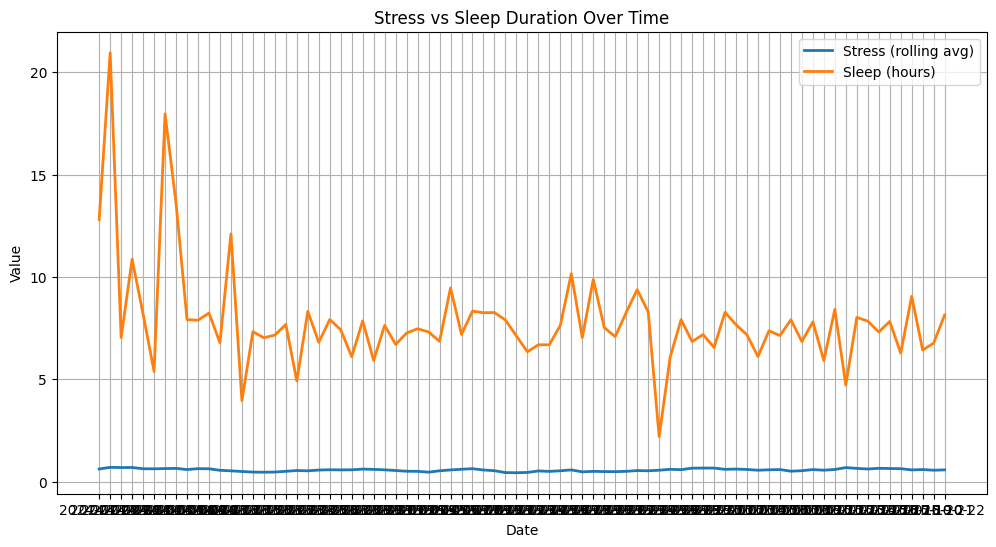

In [9]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_sleep, x="date", y="stress_rolling", label="Stress (rolling avg)", linewidth=2)
sns.lineplot(data=daily_sleep, x="date", y="total_sleep_hours", label="Sleep (hours)", linewidth=2)
plt.title("Stress vs Sleep Duration Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
import os
from dotenv import load_dotenv
from openai import OpenAI

# Load API key and initialize client
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

prompt = (
    "You are a health and sleep scientist. Analyze the following HRV and stress data trends "
    "and explain how stress levels and heart rate variability affect sleep duration and quality. "
    "Keep the language simple and include actionable takeaways for recovery."
)

ai_input = daily_sleep[["date", "heart_rate_avg", "hrv", "stress_score", "total_sleep_hours"]].tail(10).to_string()

response = client.chat.completions.create(
    model=os.getenv("GPT_MODEL"),
    messages=[
        {"role": "system", "content": "You are a data-driven sleep scientist."},
        {"role": "user", "content": f"{prompt}\n\nData:\n{ai_input}"}
    ],
    temperature=0.7
)

print("🧠 AI Analysis:\n")
print(response.choices[0].message.content)

🧠 AI Analysis:

Your heart rate variability (HRV) and stress levels seem balanced, likely contributing to your consistent sleep duration. Try maintaining your current bedtime and continue monitoring.
